In [1]:
%matplotlib inline
%matplotlib widget
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
LW=5 # linewidth
MS=10 # markersize
from scipy import stats
import time as tm

In [2]:
## sorularim:
# particle filter samples neden 100 500 olmasi gerekirken


# yapilacaklar
# 1.soruda time.time koyup farkini al
# boktalari bir kere disarda yarat iceri al ve kullan



In [3]:
# PENDULUM

In [4]:
def pendulum(N, x0, deltat, delta, R, g=9.81):
    xout = np.zeros((N+1, 2))  
    
    m = 1 
#     yout = np.zeros(np.round_(int(N/delta)))
    yout = np.zeros(int(np.ceil(N/delta)))
#     yout = yout.squeeze()
#     print(yout.shape)
#     print(delta)

    
    xout[:,0] = x0[0,0]
    xout[:,1] = x0[0,1]
    

    for ii in range(N):
#         q = np.dot(np.linalg.cholesky(Q),np.random.randn(2))
#         qx1 = q[0]
#         qx2 = q[1]
        xout[ii+1, 0] = (xout[ii, 0] + xout[ii, 1]*deltat)# + qx1
        xout[ii+1, 1] = (xout[ii, 1] - g*np.sin(xout[ii, 0])*deltat)# + qx2
        if ii%delta == 0: # and ii != 0:
            rx = np.sqrt(R) * np.random.randn(1)
#             print(ii)
#             print(int(ii/delta))
#             print(yout.shape)
            yout[int(ii/delta)] = np.sin(xout[ii, 0]) + rx 
    return xout, yout

In [5]:
# KF

In [6]:
def linear_prediction_step(A, mean, cov, sigma, deltat):
    """Linear Prediction Step: Propagate uncertainty for one time step

    X_{k+1} = A X_{k} + xi, xi sim mathcal{N}{0, noise_cov}
    X_{k} sim mathcal{N}(mean, cov)

    Inputs
    ------
    A: (d, d) linear matrix
    mean: (d, ) prior mean
    cov: (d, d) prior covariance, symmetric positive definite
    sigma (noise_cov): (d, d) process noise covariance, symmetric positive definite

    Returns
    -------
    pred_mean: (d, ) predicted mean phi(m_{k-1})
    pred_cov: (d, d) predicted covariance (ACA^T+Sigma)
    """

    pred_mean = np.array([[(mean[0] + mean[1]*deltat)],
                          [(mean[1] - g*np.sin(mean[0])*deltat)]])
    

    pred_cov = np.dot(A, np.dot(cov, A.T)) + sigma
    
    return pred_mean, pred_cov

In [7]:
def linear_update_step(data, H, mean, cov, gamma):
    """Linear Gaussian Inverse Problem
    
    Inputs
    ------
    data: (N) array of data
    H for us (A): (N, d) linear model
    mean: (d) prior mean
    cov: (d, d) prior covariance
    noise_cov : (N, N) noise covariance matrix
    
    Returns
    -------
    update_mean: (d, ) updated mean
    update_cov: (d, d) updated covariance
    
    """
#     mean = mean.T
    mu =  np.sin(mean[0])
    delta = data - mu
    S = np.dot(H, np.dot(cov, H.T)) + gamma
    U = np.dot(cov, H.T)

    USinv = U/S

#     USinv = np.dot(U, (1/S))
#     print(mean.shape)
#     print(USinv.shape)  
#     update_mean = mean + np.dot(USinv, delta)
    update_mean = mean + USinv*delta
    update_cov = cov - np.dot(USinv, U.T)
#     print((USinv*delta).shape)
#     print(update_mean.shape)
#     print(update_cov.shape)
#     update_mean = update_mean.T

#     USinv = np.dot(U, np.linalg.inv(S))
#     update_mean = mean + np.dot(USinv, delta)
#     update_cov = cov - np.dot(USinv, U.T)   
      
#     update_mean = mean + np.dot(U, np.linalg.solve(S, delta))
#     update_cov = cov - np.dot(U, np.linalg.solve(S, U.T))

    update_mean = update_mean.squeeze()
    return update_mean, update_cov

In [8]:
def kalman_filter(N,data, proc_cov, meas_cov, prior_mean, prior_cov, deltat, delta):
    """The Kalman filter
    
    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    A: (d, d), dynamics 
    proc_cov: (d,d), process noise covariance
    H: (m, d), observation operator
    meas_cov: (m, m), measurement noise covariance
    prior_mean: (d, ) prior mean
    prior_cov: (d, d), prior_covariance
    
    Return
    ------
    mean_store: (N+1, d): posterior means (first row is the prior)
    cov_store: (d, d, N+1): posterior covariances (first block is the prior)    
    """
    
#     print(prior_mean.shape)
    d = prior_mean.shape[0]
#     print(d)
#     N = data.shape[0]
#     m = data.shape[1]
    
    mean_store = np.zeros((d,N+1))
#     print(d)
#     print(N+1)
#     print(mean_store.shape)
#     mean_store[:,0] = np.copy(prior_mean)
    mean_store[:,0] = np.copy((prior_mean).squeeze())
#     print(mean_store)
#     print(mean_store.shape)
    cov_store = np.zeros((d, d, N+1))
    cov_store[:, :, 0] = np.copy(prior_cov)
    
    #Loop over all data
    for ii in range(N):
        
        mean_ii = np.reshape(mean_store[:,ii], (2, 1))
#         print(mean_ii)
        
        # update A
        
        A = np.array([[1, deltat], [-g*deltat*np.cos(mean_store[0,ii]), 1]])
        
        # Prediction
        
        pred_mean, pred_cov = linear_prediction_step(A, mean_ii, cov_store[:, :, ii], proc_cov, deltat)

        pred_mean = np.reshape(pred_mean,(2,1))
        
#         print(pred_mean)
#         print(pred_mean.shape)
        
        # update H
        
        H = np.array([[np.cos(int(pred_mean[0,:])), 0]])
#         print(pred_mean[0,:])
        
        # Update if measurement is available
        if ii%delta == 0:
        
            mean_store[:,ii+1], cov_store[:, :, ii+1] = linear_update_step(data[int(ii/delta)], H, pred_mean, pred_cov, meas_cov)
        
        else:
        
            mean_store[:,ii+1]   = pred_mean.squeeze()
            cov_store[:, :, ii+1] = pred_cov
        
    return mean_store, cov_store

In [9]:
def get_std(cov):
    """Get square root of diagonals (standard deviations) from covariances """
    
    d, d, N = cov.shape
    std_devs = np.zeros((N, d))
    for ii in range(N):
        std_devs[ii, :] = np.sqrt(np.diag(cov[:, :, ii]))
    return std_devs


In [10]:
# g=9.81
# deltat = 0.01
# x0 = np.array([[1.5,0]])

# qc = 0.1
# Q = np.array([[(qc*deltat**3)/3 , (qc*deltat**2)/2 ],
#               [(qc*deltat**2)/2 ,  qc*deltat]])
# N = 500
# deltaArray = np.array([5,10,20,40])
# RArray = np.array([1, 0.1, 0.01, 0.001]) 
                    
# fig, sp = plt.subplots(4,4,figsize=(15,15))                    
# for i in range(np.size(deltaArray)):
#     delta = deltaArray[i]
#     for j in range(np.size(RArray)):
#         R = RArray[j] 
#         xout, yout = pendulum(N, x0, deltat, delta, R, g=9.8)
#         yuse = yout
#         # prior_mean = np.zeros((2)) # prior mean
#         prior_mean = x0.T # prior mean
#         prior_cov = np.eye(2)  # prior covariance
#         proc_cov = Q # 1e-1 * np.eye(2) # process noise covariance
#         meas_cov = R # 1e-1 * np.eye(H.shape[0]) #measurement noise covariance
#         meanpost, covpost = kalman_filter(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, deltat, delta)
#         std_devs = get_std(covpost) #extract the standard deviations at all the states
        
#         T = N*deltat
#         t = np.linspace(0, T, N+1)
#         ty = np.linspace(0, T, int(np.ceil((N/delta))))
#         sp[j,i].plot(t, xout[:, 0],'--', color='purple', label='True Angle')
#         sp[j,i].plot(ty, yout, 'co', alpha=0.5, label='Angle Measurements')
#         sp[j,i].plot(t, meanpost[0,:], color='purple', label='KF Angle Estimate')
#         sp[j,i].fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
#                 color='purple', alpha=0.3)

#         if i == 0:
#             sp[j,i].set_ylabel('R = ' +str(R),fontsize=10)
#         if j == (np.size(deltaArray)-1) :
#             sp[j,i].set_xlabel('Time', fontsize=10)
#         if j == 0:
#             sp[j,i].set_title('$\delta$ = ' +str(delta))
        
# sp[j,i].legend(bbox_to_anchor=(1,0), loc="lower right", 
#                 bbox_transform=fig.transFigure, ncol=1) 

# fig.suptitle('Extended KF',fontsize=12)
# plt.show



In [11]:
## UKF

In [12]:

def nonlinphi(x):
    g = 9.81
    N = x.shape[0]
    out = np.zeros((x.shape[0], 2))
#     print(out.shape)
#     print(x)
    out[:, 0] = x[:,0] + x[:,1]*deltat #+ np.random.randn(N)
    out[:, 1] = x[:,1] - g*np.sin(x[:,0])*deltat #+ np.random.randn(N)
    
    return out

def nonlinh(x):
#     print(x)
#     print(x.shape)
    N = x.shape[0]
    out = np.zeros((x.shape[0], 1))
    out[:, 0] = np.sin(x[:,0]) 
    return out

In [13]:
def plot_points(N, cov, func, tpoints):
    """Plot a Gaussian and a Transformed Variable
    
    Inputs
    ------
    N: number of samples
    cov: covariance of the gaussian
    func: nonlinear function to visualize
    tpoints: (N, 2) array of any special input points we might want to see transformed    
    
    Returns
    -------
    fig, axs, tpt
    tpt is (N, 2) array of transformed points or none if tpoints is None
    """
    
    # Sample from the Gaussian (mean 0)
    L = np.linalg.cholesky(cov)
    x = np.dot(L, np.random.randn(2, N)).T

    # Plot the "original" points
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(x[:, 0], x[:, 1], 'o', ms=1)
    #axs[0].plot(0, 0, 'o', color='black', ms=10)
    if tpoints is not None:
        axs[0].plot(tpoints[:, 0], tpoints[:, 1], 'go', ms=10)
    axs[0].set_title("Original", fontsize=14)
    axs[0].set_xlabel(r'$X_1$', fontsize=14)
    axs[0].set_ylabel(r'$X_2$', fontsize=14)
    
    xt = func(x)
#     print(xt.shape)
    axs[1].plot(xt[:, 0], xt[:, 1], 'ro', ms=1)
    #mt = np.mean(xt, axis=0)
    #axs[1].plot(mt[0], mt[1], 'o', color='black', ms=10)

    tpt = None
    if tpoints is not None:
        tpt = func(tpoints)
        axs[1].plot(tpt[:, 0], tpt[:, 1], 'go', ms=10)
    axs[1].set_title("Transformed", fontsize=14)
    axs[1].set_xlabel(r'$Y_1$', fontsize=14)
    axs[1].set_ylabel(r'$Y_2$', fontsize=14)
    
    return fig, axs, tpt

In [14]:
def unscented_points(mean, cov, alg='chol', alpha=1, beta=0, kappa=0):
    """Generate unscented points"""    
    dim = cov.shape[0]
    lam = alpha*alpha*(dim + kappa) - dim
    if alg == "chol":
#         print(cov)
        L = np.linalg.cholesky(cov)
    elif alg == "svd":
        u, s, v = np.linalg.svd(cov)
        L = np.dot(u, np.sqrt(np.diag(s)))
        
    pts = np.zeros((2*dim+1, 2))
    pts[0, :] = mean

    
    for ii in range(1, dim+1):        
        pts[ii, :] = mean + np.sqrt(dim + lam)*L[:, ii-1]
        pts[ii+dim,:] = mean - np.sqrt(dim + lam)*L[:, ii-1]

    W0m = lam / (dim + lam)
    W0C = lam / (dim + lam) + (1 - alpha*alpha + beta)
    Wim = 1/2 / (dim + lam)
    Wic = 1/2 / (dim + lam)
    return pts, (W0m, Wim, W0C, Wic)

In [15]:
def UKF_prediction_step(mean, cov, sigma, alpha=1, beta=0, kappa=0):
    
    dimPre = cov.shape[0]
    UP, w = unscented_points(mean, cov, alg='chol') # returns: pts, (W0m, Wim, W0C, Wic)

    # Mean

    u0 = np.reshape(UP[0,:], (dimPre,1))
    dynamicsOutMean0 = nonlinphi(u0.T)*w[0]
    dynamicsOutMean0 = np.reshape(dynamicsOutMean0, (1, dimPre))
    dynamicsOutMean  = dynamicsOutMean0

    for jj in range(1,UP.shape[0]):
        ui = np.reshape(UP[jj,:], (dimPre,1))
        dynamicsOutMeani = nonlinphi(ui.T)*w[1]
        dynamicsOutMean = dynamicsOutMean + dynamicsOutMeani
    
    pred_mean = dynamicsOutMean

    # Cov

    dynamicsOutCov0 = np.dot((nonlinphi(u0.T)- pred_mean).T,\
                             ((nonlinphi(u0.T)- pred_mean).T).T)*w[2]
    dynamicsOutCov  = dynamicsOutCov0
    
    for jj in range(1,UP.shape[0]):
        ui = np.reshape(UP[jj,:], (dimPre,1))
        dynamicsOutCovi = np.dot((nonlinphi(ui.T)- pred_mean).T,\
                                ((nonlinphi(ui.T)- pred_mean).T).T)*w[3] 

        dynamicsOutCov  = dynamicsOutCov + dynamicsOutCovi   
                                   
    pred_cov = dynamicsOutCov + sigma

    return pred_mean, pred_cov

In [16]:
def UKF_update_step(data, mean, cov, gamma, alpha=1, beta=0, kappa=0):
    
    dimPre = cov.shape[0]
    
    UP, w = unscented_points(mean, cov, alg='chol') # returns pts, (W0m, Wim, W0C, Wic)

    # Mean
    u0 = np.reshape(UP[0,:], (dimPre,1))
    dynamicsOutMean0 = nonlinh(u0.T)*w[0]
    dynamicsOutMean  = dynamicsOutMean0
    
    for jj in range(1,UP.shape[0]):
        ui = np.reshape(UP[jj,:], (dimPre,1))
        dynamicsOutMeani = nonlinh(ui.T)*w[1]
        dynamicsOutMean = dynamicsOutMean + dynamicsOutMeani
    
    mu = dynamicsOutMean
    delta = data - mu
        
    # Cov

    dynamicsOutU0 = np.dot((u0 - mean.T),\
                           (nonlinh(u0.T)- mu).T)*w[2]
    dynamicsOutU  = dynamicsOutU0
    for jj in range(1,UP.shape[0]):
        ui = np.reshape(UP[jj,:], (dimPre,1))
        dynamicsOutUi = np.dot((ui - mean.T),\
                               (nonlinh(ui.T)- mu).T)*w[3] 
        dynamicsOutU  = dynamicsOutU + dynamicsOutUi           
        
        
    dynamicsOutS0 = np.dot((nonlinh(u0.T)- mu),\
                           (nonlinh(u0.T)- mu).T)*w[2]
    dynamicsOutS  = dynamicsOutS0
    for jj in range(1,UP.shape[0]):
        ui = np.reshape(UP[jj,:], (dimPre,1))
        dynamicsOutSi = np.dot((nonlinh(ui.T)- mu),\
                               (nonlinh(ui.T)- mu).T)*w[3] 
        dynamicsOutS  = dynamicsOutS + dynamicsOutSi   
                                   
    S = dynamicsOutS + gamma
    U = dynamicsOutU
    USinv = U/S
    
    update_mean = mean + (np.dot(USinv,delta)).T
    update_cov  = cov - np.dot(USinv, U.T)
    update_mean = update_mean.squeeze()

    return update_mean, update_cov

In [17]:
def UKF(N,data, proc_cov, meas_cov, prior_mean, prior_cov, delta):

    d = prior_mean.shape[0]
    mean_store = np.zeros((d,N+1))
    mean_store[:,0] = np.copy((prior_mean).squeeze())
    cov_store = np.zeros((d, d, N+1))
    cov_store[:, :, 0] = np.copy(prior_cov)
    
    #Loop over all data
    for ii in range(N):
        mean_ii = mean_store[:,ii]
        
        # Prediction
        pred_mean, pred_cov = UKF_prediction_step(mean_ii, cov_store[:, :, ii], proc_cov, alpha=1, beta=0, kappa=0)
        
        # Update if measurement is available
        if ii%delta == 0:
            mean_store[:,ii+1], cov_store[:, :, ii+1] = UKF_update_step(data[int(ii/delta)],pred_mean, pred_cov, meas_cov, alpha=1, beta=0, kappa=0)
        else:
            mean_store[:,ii+1]   = pred_mean.squeeze()
            cov_store[:, :, ii+1] = pred_cov
        
    return mean_store, cov_store

In [18]:
# g=9.81
# deltat = 0.01
# x0 = np.array([[1.5,0]])

# qc = 0.1
# Q = np.array([[(qc*deltat**3)/3 , (qc*deltat**2)/2 ],
#               [(qc*deltat**2)/2 ,  qc*deltat]])
# N = 500
# deltaArray = np.array([5,10,20,40])
# RArray = np.array([1, 0.1, 0.01, 0.001]) 
                    
# fig, sp = plt.subplots(4,4,figsize=(15,15))                    
# for i in range(np.size(deltaArray)):
#     delta = deltaArray[i]
# #     print(i)
#     for j in range(np.size(RArray)):
#         R = RArray[j] 
# #         print(j)
#         xout, yout = pendulum(N, x0, deltat, delta, R, g=9.8)
#         yuse = yout
        
#         prior_mean = x0.T # prior mean
#         prior_cov = np.eye(2)  # prior covariance
#         proc_cov = Q # 1e-1 * np.eye(2) # process noise covariance
#         meas_cov = R # 1e-1 * np.eye(H.shape[0]) #measurement noise covariance
#         meanpost, covpost = UKF(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, delta)
#         std_devs = get_std(covpost) #extract the standard deviations at all the states
        
#         T = N*deltat
#         t = np.linspace(0, T, N+1)
#         ty = np.linspace(0, T, int(np.ceil((N/delta))))
#         sp[j,i].plot(t, xout[:, 0],'--', color='purple', label='True Angle')
#         sp[j,i].plot(ty, yout, 'co', alpha=0.5, label='Angle Measurements')
#         sp[j,i].plot(t, meanpost[0,:], color='purple', label='UKF Angle Estimate')
#         sp[j,i].fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
#                 color='purple', alpha=0.3)

#         if i == 0:
#             sp[j,i].set_ylabel('R = ' +str(R),fontsize=10)
#         if j == (np.size(deltaArray)-1) :
#             sp[j,i].set_xlabel('Time', fontsize=10)
#         if j == 0:
#             sp[j,i].set_title('$\delta$ = ' +str(delta))
        
# sp[j,i].legend(bbox_to_anchor=(1,0), loc="lower right", 
#                 bbox_transform=fig.transFigure, ncol=1) 

# fig.suptitle('UKF',fontsize=12)
# plt.show



In [19]:
# Gauss Hermite KF 3rd Order 

In [20]:
def gh_oned(num_pts):
    """Gauss-hermite quadrature in 1D"""
    A = np.zeros((num_pts, num_pts))
    for ii in range(num_pts):
#         print("ii ", ii, ii==0, ii==(order-1))
        row = ii+1
        if ii == 0:
            A[ii, ii+1] = np.sqrt(row)
            A[ii+1, ii] = np.sqrt(row)
        elif ii == (num_pts-1):
            A[ii-1, ii] = np.sqrt(ii)
        else:
            A[ii, ii+1] = np.sqrt(row)
            A[ii+1, ii] = np.sqrt(row)
    pts, evec = np.linalg.eig(A)
    devec = np.dot(evec.T, evec)
    wts = evec[0,:]**2
    
    return pts, wts

def tensorize(nodes):
    """Tensorize nodes to obtain twod"""
    n1d = nodes.shape[0]
    twodnodes = np.zeros((n1d*n1d, 2))
    ind = 0
    for ii in range(n1d):
        for jj in range(n1d):
            twodnodes[ind, :] = np.array([nodes[ii], nodes[jj]])
            ind +=1
    return twodnodes

def gauss_hermite(dim, num_pts):
    """Gauss-hermite quadrature in 2D"""
    assert dim == 2, "Tensorize only implemented for dim=2"
    pts, weights = gh_oned(num_pts)
    ptsT = tensorize(pts)
    weightsT = tensorize(weights)
    weightsT = np.prod(weightsT, axis=1)
    return ptsT, weightsT

def rotate_points(points, mean, cov, alg="chol"):
    """Rotating points from standard gaussian to target Gaussian"""
    if alg == "chol":
        L = np.linalg.cholesky(cov)
    elif alg == "svd":
        u, s, v = np.linalg.svd(cov)
        L = np.dot(u, np.sqrt(np.diag(s)))
   
    # L = L*np.sqrt(2)
#     print(L)
    new_points = np.zeros(points.shape)
    for ii in range(points.shape[0]):
        new_points[ii, :] = mean + np.dot(L, points[ii,:].T)
    return new_points

In [21]:
def plot_points(N, cov, func, tpoints):
    """Plot a Gaussian and a Transformed Variable
    
    Inputs
    ------
    N: number of samples
    cov: covariance of the gaussian
    func: nonlinear function to visualize
    tpoints: (N, 2) array of any special input points we might want to see transformed    
    
    Returns
    -------
    fig, axs, tpt
    tpt is (N, 2) array of transformed points or none if tpoints is None
    """
    
    # Sample from the Gaussian (mean 0)
    L = np.linalg.cholesky(cov)
    x = np.dot(L, np.random.randn(2, N)).T

    # Plot the "original" poiints
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(x[:, 0], x[:, 1], 'o', ms=1)
    #axs[0].plot(0, 0, 'o', color='black', ms=10)
    if tpoints is not None:
        axs[0].plot(tpoints[:, 0], tpoints[:, 1], 'go', ms=10)
    axs[0].set_title("Original", fontsize=14)
    axs[0].set_xlabel(r'$X_1$', fontsize=14)
    axs[0].set_ylabel(r'$X_2$', fontsize=14)
    
    xt = func(x)
#     print(x)
    axs[1].plot(xt[:, 0], xt[:, 1], 'ro', ms=1)
    #mt = np.mean(xt, axis=0)
    #axs[1].plot(mt[0], mt[1], 'o', color='black', ms=10)

    tpt = None
    if tpoints is not None:
        tpt = func(tpoints)
        axs[1].plot(tpt[:, 0], tpt[:, 1], 'go', ms=10)
    axs[1].set_title("Transformed", fontsize=14)
    axs[1].set_xlabel(r'$Y_1$', fontsize=14)
    axs[1].set_ylabel(r'$Y_2$', fontsize=14)
    
    return fig, axs, tpt

In [22]:
# ghu_points, gh_w = gauss_hermite(2, num_pts=2) # unrotated quadrature nodes
# gh_points = rotate_points(ghu_points, np.zeros((2)), Q, alg="chol")
# print(gh_w.shape)
# print(gh_w)
# fig, axs, _ = plot_points(1000, Q, nonlinphi, gh_points)

In [23]:

def nonlinphi(x):
    g = 9.81
    N = x.shape[0]
    out = np.zeros((x.shape[0], 2))
#     print(out.shape)
#     print(x)
    out[:, 0] = x[:,0] + x[:,1]*deltat #+ np.random.randn(N)
    out[:, 1] = x[:,1] - g*deltat*np.sin(x[:,0]) #+ np.random.randn(N)
    
    return out

def nonlinh(x):
#     print(x)
#     print(x.shape)
    N = x.shape[0]
    out = np.zeros((x.shape[0], 1))
    out[:, 0] = np.sin(x[:,0]) 
    return out


# fig, axs, tpt = plot_points(1000, Q, nonlinphi, None)


In [24]:
def GHKF_prediction_step(mean, cov, sigma):
    
    dimPre = cov.shape[0]
#     dimPre = orderd
    lam = 0
    
    ghu_points, gh_w = gauss_hermite(dimPre, orderd) # unrotated quadrature nodes
    w=gh_w
    gh_points = rotate_points(ghu_points, mean, cov, alg="chol") # 9x2 num_pts=3 icin

    # Mean
    
    dynamicsOutMean  = 0
#     print(ghu_points.shape)

    
    for jj in range(gh_points.shape[0]):
        ui = np.reshape(gh_points[jj,:], (dimPre,1))
        dynamicsOutMeani = nonlinphi(ui.T)
        dynamicsOutMean = dynamicsOutMean + dynamicsOutMeani*w[jj]
    
    pred_mean = dynamicsOutMean
#     print(pred_mean)
    
    # Cov

    dynamicsOutCov  = 0
    
    for jj in range(gh_points.shape[0]):
        ui = np.reshape(gh_points[jj,:], (dimPre,1))
        dynamicsOutCovi =  np.dot((nonlinphi(ui.T)- pred_mean).T,\
                                 ((nonlinphi(ui.T)- pred_mean).T).T)
        dynamicsOutCov  = dynamicsOutCov + dynamicsOutCovi*w[jj]   
                                   
    pred_cov = dynamicsOutCov + sigma

#     print(pred_cov)
    return pred_mean, pred_cov

In [25]:
def GHKF_update_step(data, mean, cov,gamma):
    
    dimPre = cov.shape[0]
    lam = 0

    ghu_points, gh_w = gauss_hermite(dimPre, orderd) # unrotated quadrature nodes
    gh_points = rotate_points(ghu_points, mean, cov, alg="chol")
    w=gh_w

    
    # Mean

    dynamicsOutMean  = 0
    
    for jj in range(gh_points.shape[0]):
        ui = np.reshape(gh_points[jj,:], (dimPre,1))
        dynamicsOutMeani = nonlinh(ui.T)
        dynamicsOutMean = dynamicsOutMean + dynamicsOutMeani*w[jj]
    
    dynamicsOutMean = dynamicsOutMean
    mu = dynamicsOutMean  
 
    delta = data - mu
        
    # Cov

    dynamicsOutU  = 0
    
    for jj in range(gh_points.shape[0]):
        ui = np.reshape(gh_points[jj,:], (dimPre,1))      
        dynamicsOutUi = np.dot((ui - mean.T),\
                               (nonlinh(ui.T)- mu).T)
        dynamicsOutU  = dynamicsOutU + dynamicsOutUi*w[jj]
    
    
    dynamicsOutU = dynamicsOutU
        
    dynamicsOutS  = 0
    
    for jj in range(gh_points.shape[0]):
        ui = np.reshape(gh_points[jj,:], (dimPre,1)) 
        dynamicsOutSi = np.dot((nonlinh(ui.T)- mu),\
                               (nonlinh(ui.T)- mu).T)
        dynamicsOutS  = dynamicsOutS + dynamicsOutSi*w[jj]
        
    dynamicsOutS = dynamicsOutS
                                   
    S = dynamicsOutS + gamma
    U = dynamicsOutU    
    USinv = U/S
    
    update_mean = mean + (USinv*delta).T
    update_cov = cov - np.dot(USinv, U.T)
    update_mean = update_mean.squeeze()

    return update_mean, update_cov

In [26]:
def GHKF(N,data, proc_cov, meas_cov, prior_mean, prior_cov, delta):

    d = prior_mean.shape[0]
    mean_store = np.zeros((d,N+1))
    mean_store[:,0] = np.copy((prior_mean).squeeze())
    cov_store = np.zeros((d, d, N+1))
    cov_store[:, :, 0] = np.copy(prior_cov)
    
    #Loop over all data
    for ii in range(N):
        mean_ii = mean_store[:,ii]
        # Prediction
        pred_mean, pred_cov = GHKF_prediction_step(mean_ii, cov_store[:, :, ii], proc_cov)
        # Update if measurement is available
        if ii%delta == 0:
            mean_store[:,ii+1], cov_store[:, :, ii+1] = GHKF_update_step(data[int(ii/delta)],pred_mean, pred_cov, meas_cov)
        else:
            mean_store[:,ii+1]   = pred_mean.squeeze()
            cov_store[:, :, ii+1] = pred_cov
        
    return mean_store, cov_store

In [27]:
# g=9.81
# deltat = 0.01
# x0 = np.array([[1.5,0]])

# qc = 0.1
# Q = np.array([[(qc*deltat**3)/3 , (qc*deltat**2)/2 ],
#               [(qc*deltat**2)/2 ,  qc*deltat]])

# orderd = 3
# N = 500
# deltaArray = np.array([5,10,20,40])
# RArray = np.array([1, 0.1, 0.01, 0.001]) 
                    
# fig, sp = plt.subplots(4,4,figsize=(15,15))                    
# for i in range(np.size(deltaArray)):
#     delta = deltaArray[i]
# #     print(i)
#     for j in range(np.size(RArray)):
#         R = RArray[j] 
# #         print(j)
#         xout, yout = pendulum(N, x0, deltat, delta, R, g=9.8)
#         yuse = yout
        
#         prior_mean = x0.T # prior mean
#         prior_cov = np.eye(2)  # prior covariance
#         proc_cov = Q # 1e-1 * np.eye(2) # process noise covariance
#         meas_cov = R # 1e-1 * np.eye(H.shape[0]) #measurement noise covariance
#         meanpost, covpost = GHKF(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, delta)
#         std_devs = get_std(covpost) #extract the standard deviations at all the states
        
#         T = N*deltat
#         t = np.linspace(0, T, N+1)
#         ty = np.linspace(0, T, int(np.ceil((N/delta))))
#         sp[j,i].plot(t, xout[:, 0],'--', color='purple', label='True Angle')
#         sp[j,i].plot(ty, yout, 'co', alpha=0.5, label='Angle Measurements')
#         sp[j,i].plot(t, meanpost[0,:], color='purple', label='GHKF 3rd order Angle Estimate')
#         sp[j,i].fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
#                 color='purple', alpha=0.3)

#         if i == 0:
#             sp[j,i].set_ylabel('R = ' +str(R),fontsize=10)
#         if j == (np.size(deltaArray)-1) :
#             sp[j,i].set_xlabel('Time', fontsize=10)
#         if j == 0:
#             sp[j,i].set_title('$\delta$ = ' +str(delta))
        
# sp[j,i].legend(bbox_to_anchor=(1,0), loc="lower right", 
#                 bbox_transform=fig.transFigure, ncol=1) 

# fig.suptitle('GHKF3',fontsize=12)
# plt.show




In [28]:
# Gauss Hermite KF 5th Order 

In [29]:
# g=9.81
# deltat = 0.01
# x0 = np.array([[1.5,0]])

# qc = 0.1
# Q = np.array([[(qc*deltat**3)/3 , (qc*deltat**2)/2 ],
#               [(qc*deltat**2)/2 ,  qc*deltat]])

# orderd = 5
# N = 500
# deltaArray = np.array([5,10,20,40])
# RArray = np.array([1, 0.1, 0.01, 0.001]) 
                    
# fig, sp = plt.subplots(4,4,figsize=(15,15))                    
# for i in range(np.size(deltaArray)):
#     delta = deltaArray[i]
# #     print(i)
#     for j in range(np.size(RArray)):
#         R = RArray[j] 
# #         print(j)
#         xout, yout = pendulum(N, x0, deltat, delta, R, g=9.8)
#         yuse = yout
        
#         prior_mean = x0.T # prior mean
#         prior_cov = np.eye(2)  # prior covariance
#         proc_cov = Q # 1e-1 * np.eye(2) # process noise covariance
#         meas_cov = R # 1e-1 * np.eye(H.shape[0]) #measurement noise covariance
#         meanpost, covpost = GHKF(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, delta)
#         std_devs = get_std(covpost) #extract the standard deviations at all the states
        
#         T = N*deltat
#         t = np.linspace(0, T, N+1)
#         ty = np.linspace(0, T, int(np.ceil((N/delta))))
#         sp[j,i].plot(t, xout[:, 0],'--', color='purple', label='True Angle')
#         sp[j,i].plot(ty, yout, 'co', alpha=0.5, label='Angle Measurements')
#         sp[j,i].plot(t, meanpost[0,:], color='purple', label='GHKF 3rd order Angle Estimate')
#         sp[j,i].fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
#                 color='purple', alpha=0.3)

#         if i == 0:
#             sp[j,i].set_ylabel('R = ' +str(R),fontsize=10)
#         if j == (np.size(deltaArray)-1):
#             sp[j,i].set_xlabel('Time', fontsize=10)
#         if j == 0:
#             sp[j,i].set_title('$\delta$ = ' +str(delta))
        
# sp[j,i].legend(bbox_to_anchor=(1,0), loc="lower right", 
#                 bbox_transform=fig.transFigure, ncol=1) 

# fig.suptitle('GHKF5',fontsize=12)
# plt.show





In [30]:
# HEPSI

In [31]:
# aa = np.array([[1, 2, 3],[10, 10, 10]])
# print(aa)
# np.sum(aa,axis=1) # row sum
# np.sum(aa,axis=0) # col sum

totalTimeEKF 0.11933612823486328
totalTimeUKF 0.635185956954956
totalTimeGHKF3 1.328819751739502
totalTimeGHKF5 3.232374668121338


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
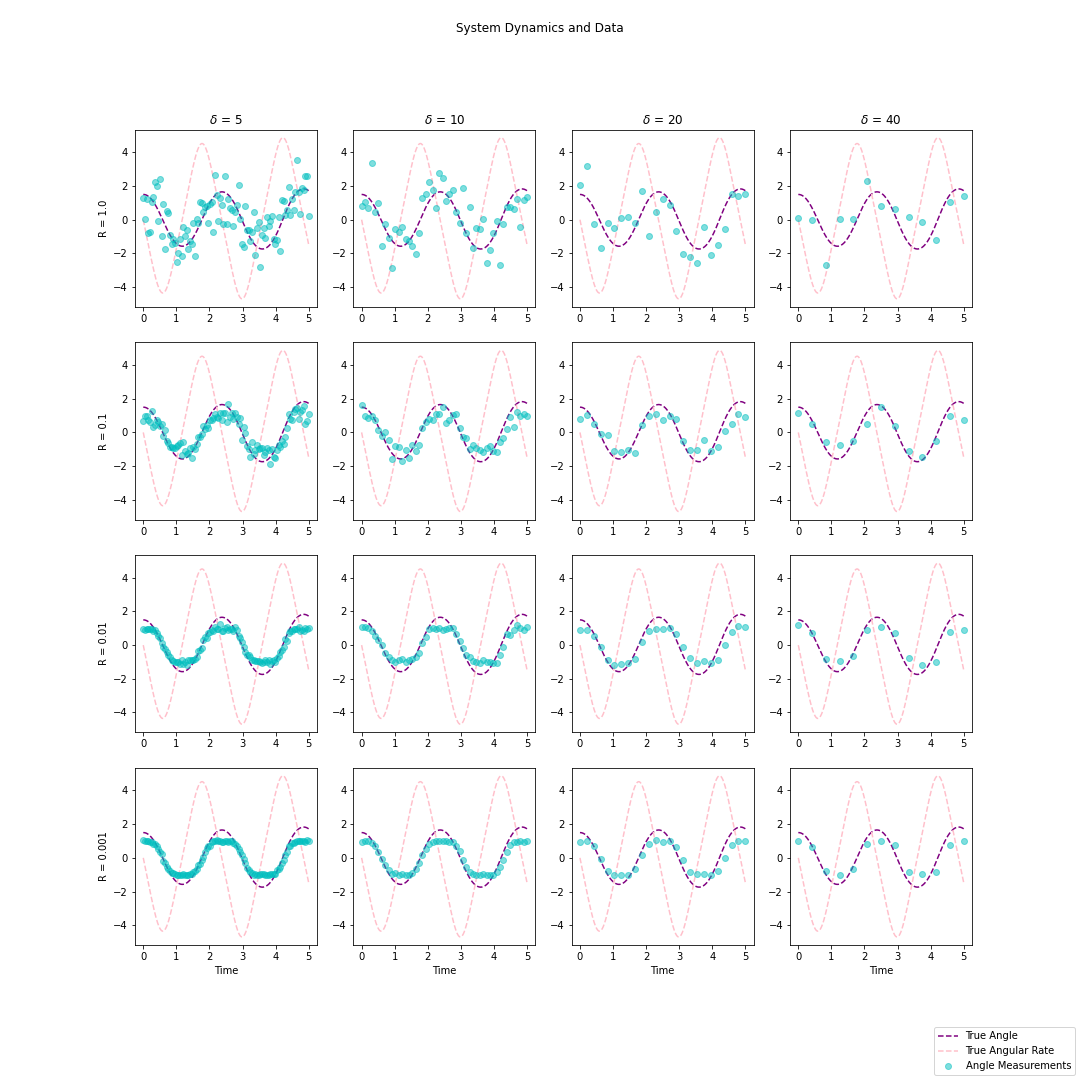

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
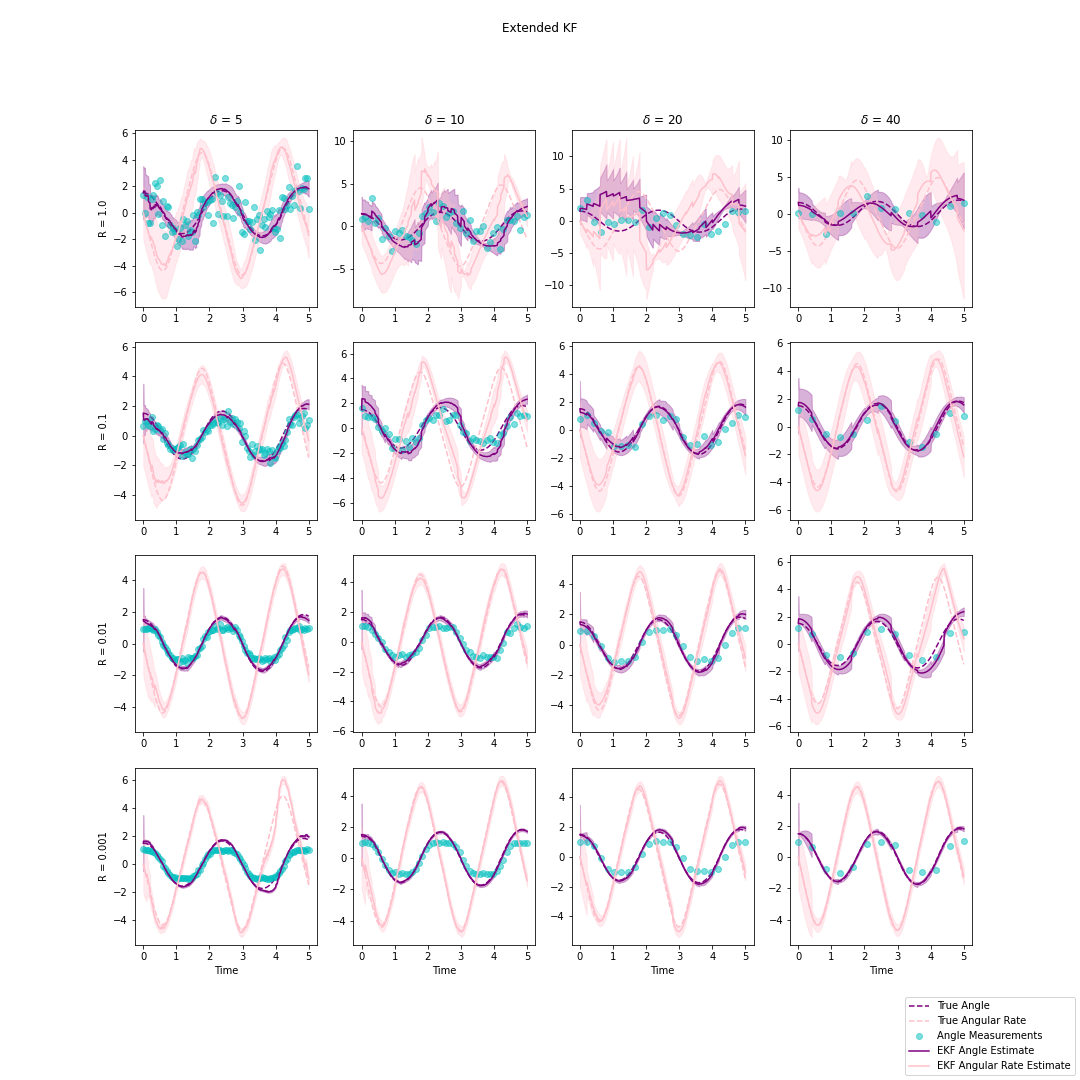

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
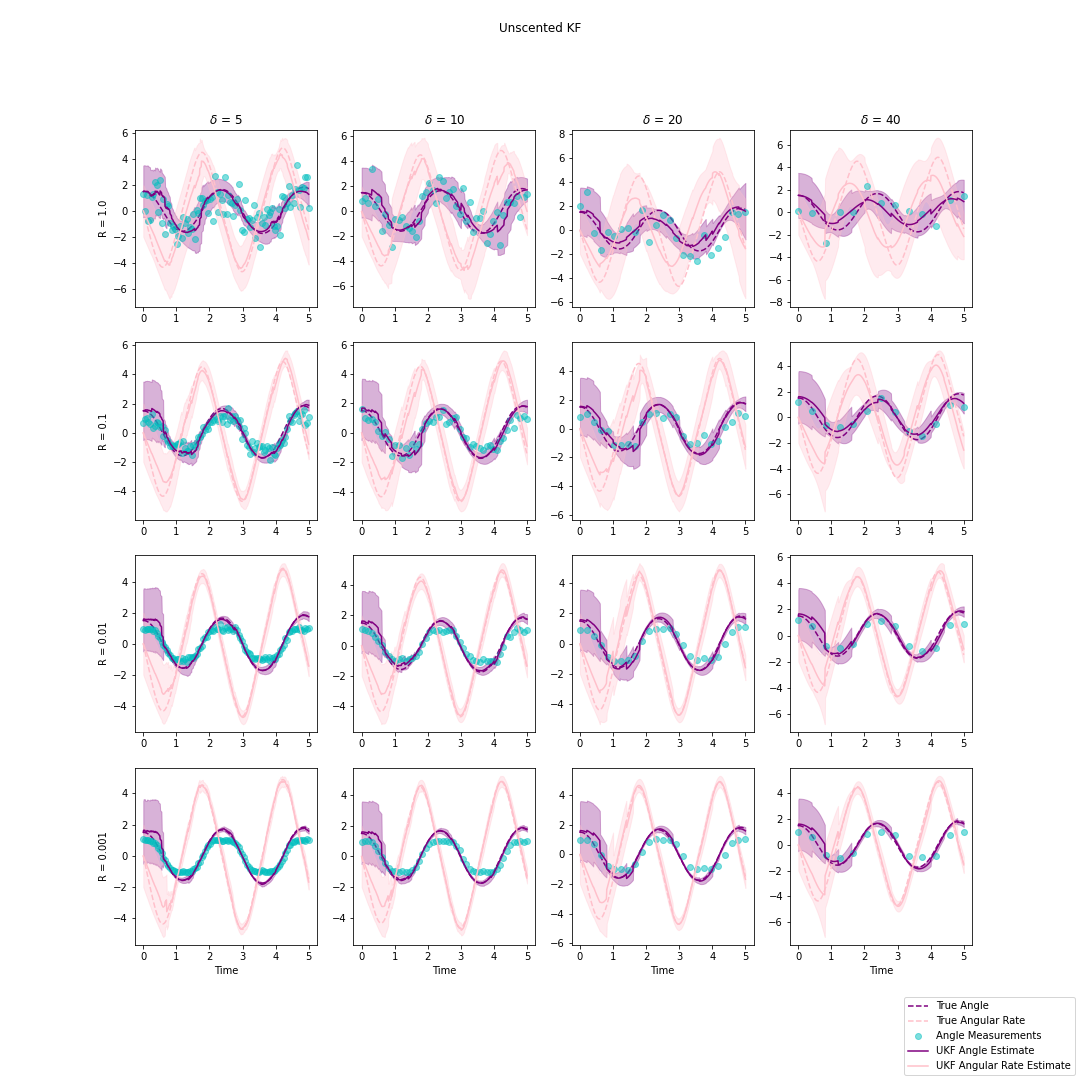

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
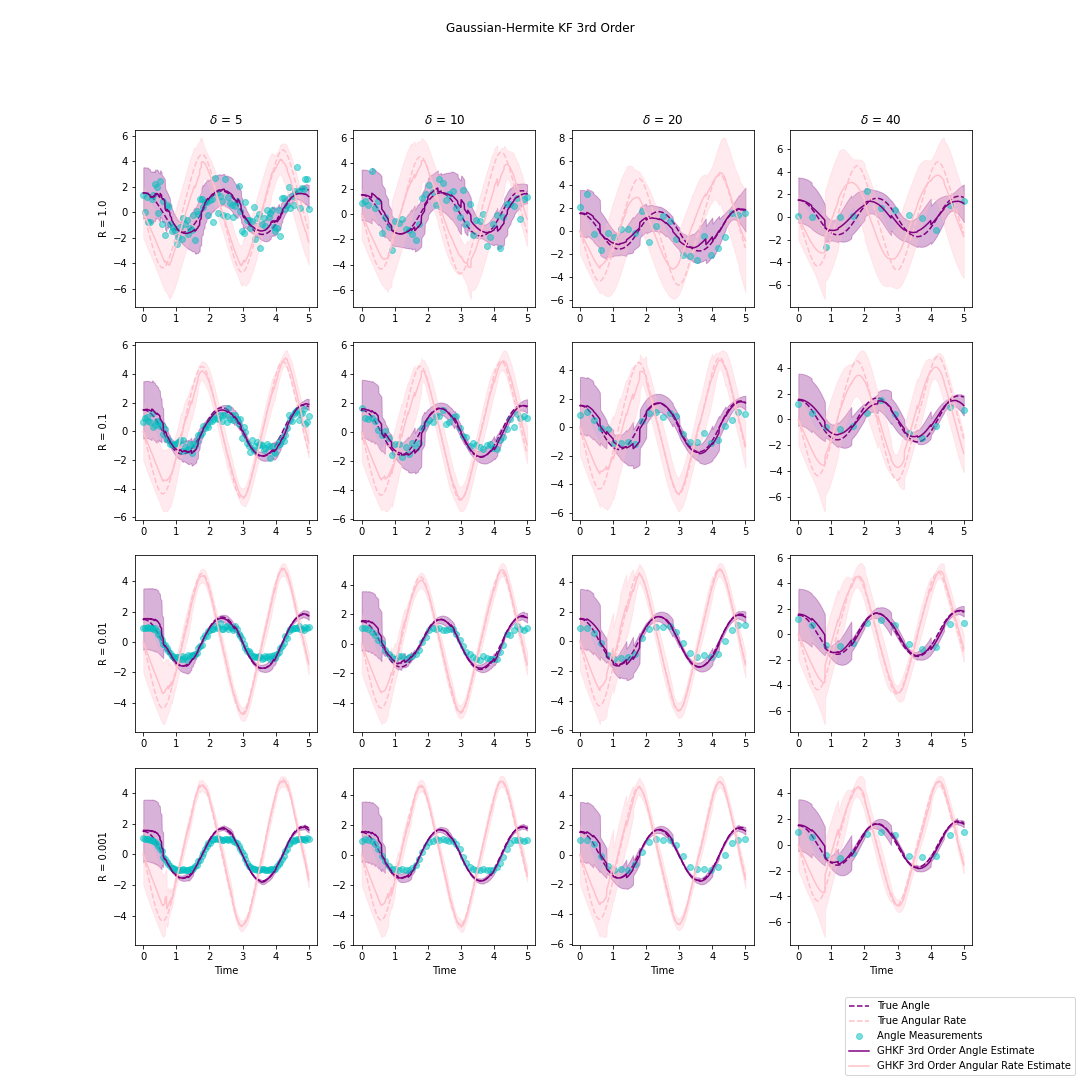

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
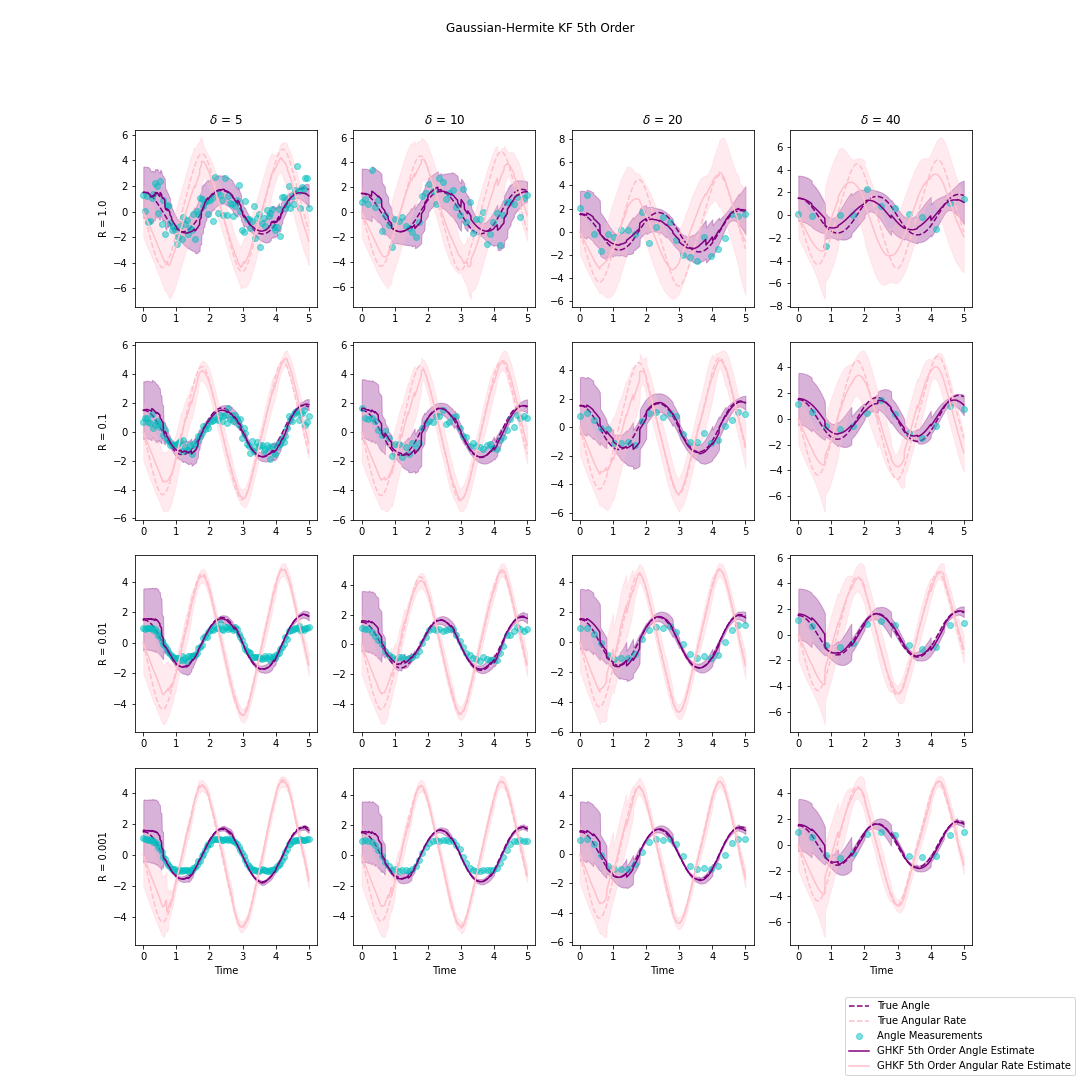

In [37]:
# time.time()
g=9.81
deltat = 0.01
x0 = np.array([[1.5,0]])

qc = 0.1
Q = np.array([[(qc*deltat**3)/3 , (qc*deltat**2)/2 ],
              [(qc*deltat**2)/2 ,  qc*deltat]])
N = 500
deltaArray = np.array([5,10,20,40])
RArray = np.array([1, 0.1, 0.01, 0.001]) 

MSEXEKF = np.zeros((2,int(np.size(deltaArray)*np.size(RArray))))
MSEXUKF = np.zeros((2,int(np.size(deltaArray)*np.size(RArray))))
MSEXGHKF3 = np.zeros((2,int(np.size(deltaArray)*np.size(RArray))))
MSEXGHKF5 = np.zeros((2,int(np.size(deltaArray)*np.size(RArray))))




fig0, sp0 = plt.subplots(4,4,figsize=(15,15))                   
fig, sp = plt.subplots(4,4,figsize=(15,15))    
fig2, sp2 = plt.subplots(4,4,figsize=(15,15)) 
fig3, sp3 = plt.subplots(4,4,figsize=(15,15))
fig4, sp4 = plt.subplots(4,4,figsize=(15,15))


totalTimeEKF = 0
totalTimeUKF = 0
totalTimeGHKF3 = 0
totalTimeGHKF5 = 0


k = 0

for i in range(np.size(deltaArray)):
    delta = deltaArray[i]
    for j in range(np.size(RArray)):
        R = RArray[j] 
        xout, yout = pendulum(N, x0, deltat, delta, R, g=9.8)
        yuse = yout
        # prior_mean = np.zeros((2)) # prior mean
        prior_mean = x0.T # prior mean
        prior_cov = np.eye(2)  # prior covariance
        proc_cov = Q # 1e-1 * np.eye(2) # process noise covariance
        meas_cov = R # 1e-1 * np.eye(H.shape[0]) #measurement noise covariance
        T = N*deltat
        t = np.linspace(0, T, N+1)
        ty = np.linspace(0, T, int(np.ceil((N/delta))))
        sp0[j,i].plot(t, xout[:, 0],'--', color='purple', label='True Angle')
        sp0[j,i].plot(t, xout[:, 1],'--', color='pink', label='True Angular Rate')
        sp0[j,i].plot(ty, yout, 'co', alpha=0.5, label='Angle Measurements')
 
        if i == 0:
            sp0[j,i].set_ylabel('R = ' +str(R),fontsize=10)
        if j == (np.size(deltaArray)-1) :
            sp0[j,i].set_xlabel('Time', fontsize=10)
        if j == 0:
            sp0[j,i].set_title('$\delta$ = ' +str(delta))
        
        
        #EKF
        startTimeEKF = tm.time()
        meanpost, covpost = kalman_filter(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, deltat, delta)
        std_devs = get_std(covpost) #extract the standard deviations at all the states
        T = N*deltat
        t = np.linspace(0, T, N+1)
        ty = np.linspace(0, T, int(np.ceil((N/delta))))
        sp[j,i].plot(t, xout[:, 0],'--', color='purple', label='True Angle')
        sp[j,i].plot(t, xout[:, 1],'--', color='pink', label='True Angular Rate')
        sp[j,i].plot(ty, yout, 'co', alpha=0.5, label='Angle Measurements')
        sp[j,i].plot(t, meanpost[0,:], color='purple', label='EKF Angle Estimate')
        sp[j,i].plot(t, meanpost[1,:], color='pink', label='EKF Angular Rate Estimate')
        sp[j,i].fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
                color='purple', alpha=0.3)
        sp[j,i].fill_between(t, meanpost[1,:] - 2 * std_devs[:, 1],  meanpost[1,:] + 2*std_devs[:, 1],
                color='pink', alpha=0.3)
        if i == 0:
            sp[j,i].set_ylabel('R = ' +str(R),fontsize=10)
        if j == (np.size(deltaArray)-1) :
            sp[j,i].set_xlabel('Time', fontsize=10)
        if j == 0:
            sp[j,i].set_title('$\delta$ = ' +str(delta))
        
        mseX1EKF = (1/N)*np.sum((xout[:, 0]-meanpost[0,:])**2,axis=0)
        mseX2EKF = (1/N)*np.sum((xout[:, 1]-meanpost[1,:])**2,axis=0)
        
        MSEXEKF[0,k] = mseX1EKF
        MSEXEKF[1,k] = mseX2EKF
        
        endTimeEKF = tm.time()
        totalTimeEKFi = endTimeEKF-startTimeEKF
        totalTimeEKF=totalTimeEKF+totalTimeEKFi
    
        
        #UKF
        startTimeUKF = tm.time()
        meanpost, covpost = UKF(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, delta)
        std_devs = get_std(covpost) #extract the standard deviations at all the states
        sp2[j,i].plot(t, xout[:, 0],'--', color='purple', label='True Angle')
        sp2[j,i].plot(t, xout[:, 1],'--', color='pink', label='True Angular Rate')
        sp2[j,i].plot(ty, yout, 'co', alpha=0.5, label='Angle Measurements')
        sp2[j,i].plot(t, meanpost[0,:], color='purple', label='UKF Angle Estimate')
        sp2[j,i].plot(t, meanpost[1,:], color='pink', label='UKF Angular Rate Estimate')
        sp2[j,i].fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
                color='purple', alpha=0.3) 
        sp2[j,i].fill_between(t, meanpost[1,:] - 2 * std_devs[:, 1],  meanpost[1,:] + 2*std_devs[:, 1],
                color='pink', alpha=0.3)
        if i == 0:
            sp2[j,i].set_ylabel('R = ' +str(R),fontsize=10)
        if j == (np.size(deltaArray)-1) :
            sp2[j,i].set_xlabel('Time', fontsize=10)
        if j == 0:
            sp2[j,i].set_title('$\delta$ = ' +str(delta))  
        
    
        
        mseX1UKF = (1/N)*np.sum((xout[:, 0]-meanpost[0,:])**2,axis=0)
        mseX2UKF = (1/N)*np.sum((xout[:, 1]-meanpost[1,:])**2,axis=0)

        MSEXUKF[0,k] = mseX1UKF
        MSEXUKF[1,k] = mseX2UKF
        
        endTimeUKF = tm.time()
        totalTimeUKFi = endTimeUKF-startTimeUKF
        totalTimeUKF = totalTimeUKF + totalTimeUKFi
            
        #GHKF 3
        startTimeGHKF3 = tm.time()
        order = 3
        orderd = int((order+1)/2)
        orderd = 3
        meanpost, covpost = GHKF(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, delta)
        std_devs = get_std(covpost) #extract the standard deviations at all the states
        sp3[j,i].plot(t, xout[:, 0],'--', color='purple', label='True Angle')
        sp3[j,i].plot(t, xout[:, 1],'--', color='pink', label='True Angular Rate')
        sp3[j,i].plot(ty, yout, 'co', alpha=0.5, label='Angle Measurements')
        sp3[j,i].plot(t, meanpost[0,:], color='purple', label='GHKF 3rd Order Angle Estimate')
        sp3[j,i].plot(t, meanpost[1,:], color='pink', label='GHKF 3rd Order Angular Rate Estimate')
        sp3[j,i].fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
                color='purple', alpha=0.3)     
        sp3[j,i].fill_between(t, meanpost[1,:] - 2 * std_devs[:, 1],  meanpost[1,:] + 2*std_devs[:, 1],
                color='pink', alpha=0.3)
        if i == 0:
            sp3[j,i].set_ylabel('R = ' +str(R),fontsize=10)
        if j == (np.size(deltaArray)-1) :
            sp3[j,i].set_xlabel('Time', fontsize=10)
        if j == 0:
            sp3[j,i].set_title('$\delta$ = ' +str(delta))         
        
        mseX1GHKF3 = (1/N)*np.sum((xout[:, 0]-meanpost[0,:])**2,axis=0)
        mseX2GHKF3 = (1/N)*np.sum((xout[:, 1]-meanpost[1,:])**2,axis=0)

        MSEXGHKF3[0,k] = mseX1GHKF3
        MSEXGHKF3[1,k] = mseX2GHKF3
        
        endTimeGHKF3 = tm.time()
        totalTimeGHKF3i = endTimeGHKF3-startTimeGHKF3
        totalTimeGHKF3 = totalTimeGHKF3 + totalTimeGHKF3i
        
        
        #GHKF 5
        startTimeGHKF5 = tm.time()
        order = 5
        orderd = int((order+1)/2)
        orderd = 5
        meanpost, covpost = GHKF(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, delta)
        std_devs = get_std(covpost) #extract the standard deviations at all the states
        sp4[j,i].plot(t, xout[:, 0],'--', color='purple', label='True Angle')
        sp4[j,i].plot(t, xout[:, 1],'--', color='pink', label='True Angular Rate')
        sp4[j,i].plot(ty, yout, 'co', alpha=0.5, label='Angle Measurements')
        sp4[j,i].plot(t, meanpost[0,:], color='purple', label='GHKF 5th Order Angle Estimate')
        sp4[j,i].plot(t, meanpost[1,:], color='pink', label='GHKF 5th Order Angular Rate Estimate')
        sp4[j,i].fill_between(t, meanpost[0,:] - 2 * std_devs[:, 0],  meanpost[0,:] + 2*std_devs[:, 0],
                color='purple', alpha=0.3) 
        sp4[j,i].fill_between(t, meanpost[1,:] - 2 * std_devs[:, 1],  meanpost[1,:] + 2*std_devs[:, 1],
                color='pink', alpha=0.3)
        if i == 0:
            sp4[j,i].set_ylabel('R = ' +str(R),fontsize=10)
        if j == (np.size(deltaArray)-1) :
            sp4[j,i].set_xlabel('Time', fontsize=10)
        if j == 0:
            sp4[j,i].set_title('$\delta$ = ' +str(delta)) 
            
        mseX1GHKF5 = (1/N)*np.sum((xout[:, 0]-meanpost[0,:])**2,axis=0)
        mseX2GHKF5 = (1/N)*np.sum((xout[:, 1]-meanpost[1,:])**2,axis=0)

        
        MSEXGHKF5[0,k] = mseX1GHKF5
        MSEXGHKF5[1,k] = mseX2GHKF5
        
        endTimeGHKF5 = tm.time()
        totalTimeGHKF5i = endTimeGHKF5-startTimeGHKF5
        totalTimeGHKF5 = totalTimeGHKF5 +totalTimeGHKF5i
        
        
#         print('Mean Squared Error for the first state EKF =',mseX1EKF,'delta=',delta,'R=',R)
#         print('Mean Squared Error for the second state EKF =',mseX2EKF,'delta=',delta,'R=',R)
#         print('Mean Squared Error for the first state UKF =',mseX1UKF,'delta=',delta,'R=',R)
#         print('Mean Squared Error for the second state UKF =',mseX2UKF,'delta=',delta,'R=',R)                 
#         print('Mean Squared Error for the first state GHKF3 =',mseX1GHKF3,'delta=',delta,'R=',R)        
#         print('Mean Squared Error for the second state GHKF3 =',mseX2GHKF3,'delta=',delta,'R=',R)       
#         print('Mean Squared Error for the first state GHKF5 =',mseX1GHKF5,'delta=',delta,'R=',R)
#         print('Mean Squared Error for the second state GHKF5 =',mseX2GHKF5,'delta=',delta,'R=',R)   
        
        k = k+1
        
sp0[j,i].legend(bbox_to_anchor=(1,0), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=1) 

fig0.suptitle('System Dynamics and Data',fontsize=12)

sp[j,i].legend(bbox_to_anchor=(1,0), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=1) 

fig.suptitle('Extended KF',fontsize=12)

sp2[j,i].legend(bbox_to_anchor=(1,0), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=1) 

fig2.suptitle('Unscented KF',fontsize=12)

sp3[j,i].legend(bbox_to_anchor=(1,0), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=1) 

fig3.suptitle('Gaussian-Hermite KF 3rd Order',fontsize=12)

sp4[j,i].legend(bbox_to_anchor=(1,0), loc="lower right", 
                bbox_transform=fig.transFigure, ncol=1) 

fig4.suptitle('Gaussian-Hermite KF 5th Order',fontsize=12)



plt.show
print('totalTimeEKF',totalTimeEKF)
print('totalTimeUKF',totalTimeUKF)
print('totalTimeGHKF3',totalTimeGHKF3)
print('totalTimeGHKF5',totalTimeGHKF5)

In [33]:
# print('MSEXEKF',MSEXEKF)
# print('MSEXUKF',MSEXUKF)
# print('MSEXGHKF3',MSEXGHKF3)
# print('MSEXGHKF5',MSEXGHKF5)

In [ ]:
# Particle Filter

In [ ]:
def resample(Nsamples, samples, weights):
    """Generate *Nsamples* samples from an empirical distribution defined by *samples* and *weights*
    
    Inputs
    ------
    Nsamples: integer, number of samples to generate
    samples: (N, d) array of N samples of dimension d that form the empirical distribution
    weights: (N, ) array of N weights
    
    Returns
    --------
    samples_out: (Nsamples, d) new samples
    weights_out: (Nsamples, ) new weights equal to 1 / N
    """

    N = samples.shape[0]  # get number of points that make up the empirical distribution
    rr = np.arange(N) # get an ordered set of numbers from 0 to N-1
    
    # Randomly choose the integers (with replacement) between 0 to N-1 with probabilities given by the weights
    samp_inds = np.random.choice(rr, Nsamples, p=weights) 

    # subselect the samples chosen
    samples_out = samples[samp_inds, :]
    
    # return uniform weights
    weights_out = np.ones((Nsamples))/Nsamples
    return samples_out, weights_out

In [ ]:
def compute_mean_std(samples, weights):
    """Compute the mean and standard deviation of multiple empirical distirbution
    
    Inputs
    ------
    samples: (N, d, m) array of samples defining the empirical distribution
    weights: (N, m) array of weights
    
    Returns
    -------
    means: (m, d) array of means
    stds: (m, d) array of standard deviations
    
    Notes
    -----
    m is the number of empirical distributions
    """
    
    N, d, m = samples.shape
    means = np.zeros((m, d))
#     print(means.shape)
    stds = np.zeros((m, d))
    for ii in range(m):
        means[ii, :] = np.dot(weights[:, ii], samples[:, :, ii])
        stds[ii, :] = np.sqrt(np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(means[ii, :], (N, 1)))**2))
    return means, stds

In [ ]:
def step(prop, proppdf, current_samples, current_weights, likelihood, data, propagator):
    """
    Propagate a particle filter
    
    @param[in] prop            - proposal function (current_state, data)
    @param[in] proppdf         - proposal function logpdf
    @param[in] current_samples - ensemble of samples
    @param[in] current_weights - ensemble of weights
    @param[in] likelihood      - function to evaluate the log likelihood (samples, data)
    @param[in] data            - Observation
    @param[in] propagator      - dynamics logpdf
    
    @returns samples and weights after assimilating the data
    """
    #new_samples = np.zeros(current_samples.shape)
    #new_weights = np.zeros(current_weights.shape)
    
    new_samples = prop(current_samples, data)
    new_weights = likelihood(new_samples, data,noise_var) + propagator(new_samples, current_samples,proc_var) - \
                            proppdf(new_samples, current_samples, data,proc_var)
    new_weights = np.exp(new_weights) * current_weights
    #for ii in range(new_samples.shape[0]):
    #    new_samples[ii, :] = prop(current_samples[ii, :], data)
    #    new_weights[ii] = np.exp(likelihood(new_samples[ii, :], data) + 
    #                                propagator(new_samples[ii, :], current_samples[ii, :]) -
    #                                proppdf(new_samples[ii, :], current_samples[ii, :], data))      
    #    new_weights[ii] *= current_weights[ii]
        
    # normalize weights
    new_weights = new_weights / np.sum(new_weights)
    return new_samples, new_weights

In [ ]:
def stepIfNoData(prop,current_samples,current_weights):
    new_samples = prop(current_samples,dt)
    return new_samples, current_weights

In [ ]:
def pendulum_dyn(current_state, dt=0.1):
    """Pendulum dynamics
    
    Inputs
    ------
    Current_state : either (2,) or (N, 2) for vectorized input
    """
    if current_state.ndim == 1:
        next_state = np.zeros((2))
        next_state[0] = current_state[0] + dt * current_state[1]
        next_state[1] = current_state[1] - dt * 9.81 * np.sin(current_state[0])
    else: # multiple inputs
        next_state = np.zeros(current_state.shape)
        next_state[:, 0] = current_state[:, 0] + dt * current_state[:, 1]
        next_state[:, 1] = current_state[:, 1] - dt * 9.81 * np.sin(current_state[:, 0])
    return next_state

def observe(current_state):
    if current_state.ndim == 1:
        out = np.zeros((1))
        out[0] = np.sin(current_state[0])
    else:
        out = np.zeros((current_state.shape[0], 1))
        out[:, 0] = np.sin(current_state[:, 0])
    return out

In [ ]:
# x0 = np.array([1.5, 0])
# dt = 0.01
# Nsteps = 500
# true = np.zeros((Nsteps, 2))
# true[0, :] = x0
# times = np.arange(0, Nsteps*dt, dt)
# data = np.zeros((int(Nsteps/delta), 1))
# print(data.shape)
# ns = 1.0 # standard deviation of noise
# noise_var = ns*ns
# delta = 5

# for ii in range(1, Nsteps):
#     true[ii, :] = pendulum_dyn(true[ii-1, :],dt=dt)
#     if (ii-1)%delta == 0 and (ii-1) != 0:
# #         print(ii-1)
#         data[int((ii-1)/delta)] = observe(true[ii, :]) + 0*np.random.randn()*ns
# #         print((ii-1)/delta)

# ty = np.linspace(0, T, int(np.ceil((N/delta))))
# # print(ty.shape)  
# # print(data.shape)



# fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# axs[0].plot(times, true[:, 0])
# axs[0].plot(ty[1:], data[1:], 'ko', ms=3)
# axs[0].set_xlabel("Time", fontsize=14)
# axs[0].set_ylabel("Position", fontsize=14)
# axs[1].plot(times, true[:, 1])
# axs[1].set_xlabel("Time", fontsize=14)
# axs[1].set_ylabel("Velocity", fontsize=14)
# plt.show()

In [ ]:
# Process noise
# proc_var=R
# proc_mat = np.zeros((2,2))
# proc_mat[0, 0] = proc_var/3.0*dt**3
# proc_mat[0, 1] = proc_var/2.0*dt**2
# proc_mat[1, 0] = proc_var/2.0*dt**2
# proc_mat[1, 1] = proc_var*dt



def proposal(current_state, dt, data=None):
    """ Bootstrap Particle Filter the proposal is the dynamics!"""
    
    if current_state.ndim == 1:
        return pendulum_dyn(current_state, dt) + np.dot(Lproc, np.random.randn(2))
    else:
        nsamples = current_state.shape[0]
        return pendulum_dyn(current_state, dt) + np.dot(Lproc, np.random.randn(2, nsamples)).T

def proposal_logpdf(current, previous, proc_var, data=None):
    """ Bootstrap Particle Filter: the proposal is the dynamics"""
    nexts  = pendulum_dyn(previous, dt)
    delta = nexts - current
    if current.ndim == 1:
        return -0.5 * np.dot(delta, np.dot(proc_mat_inv, delta))
    else:
        return -0.5 * np.sum(delta * np.dot(delta, proc_mat_inv.T), axis=1)

def likelihood(state, data, noise_var):
    """Gaussian Likelihood through nonlinear model"""
    dpropose = observe(state)
    delta = dpropose - data
    if state.ndim == 1:
        return -0.5 * np.dot(delta, delta) / noise_var
    else:
        return -0.5 * np.sum(delta * delta, axis=1) / noise_var 

In [ ]:
def particle_filter(data, prior_mean, prior_cov,                     
                    prop, proppdf, likelihood, propagator,
                    nsamples=1000, resampling_threshold_frac=0.1):
    """Particle Filter
      
    Inputs
    -------
    data: (nsteps, m) array of data points, N is the time index, m is the dimensionality of the data
    prior_mean: (d), prior mean
    prior_cov: (d, d), prior mean
    Nsamples: integer, number of samples in the empirical distribution
    resampling_threshold_frac: float between 0 and 1 indicating to resample when effective sample size below frac of nsamples

    Returns
    -------
    samples: (nsamples, d, nsteps)
    weights: (nsamples, nsteps)
    eff: (nsamples), effective sample size
    
    Notes
    -----
    For documentation of prop, proppdf, likelihood, and propagator -- see the step function
    """
    
    
    d = prior_mean.shape[0] 
    nsteps = 499 #data.shape[0] 
#     meanPF = np.zeros((nsteps+1, 2))
#     std = np.zeros((nsteps+1, 2))

    # Allocate memory
    samples = np.zeros((nsamples, d, nsteps+1))
#     print(samples.shape)
    weights = np.zeros((nsamples, nsteps+1))
    eff = np.zeros((nsteps+1)) # keep track of effective sample size at each step
    
    
    # Generate initial samples from the prior
    L = np.linalg.cholesky(prior_cov)
    samples[:, :, 0] = np.tile(prior_mean, (nsamples, 1))+ np.dot(L, np.random.randn(d, nsamples)).T
    weights[:, 0] = 1.0 / nsamples # all weights are equal because of independent sampling from prior
    eff[0] = nsamples
#     meanPF[0,:]=np.dot(weights[:,0],samples[:,:,0])
#     stdPF[0,:]= np.sqrt(np.dot(weights[:, 0], (samples[:, :, 0] - np.tile(means[0, :], (N, 1)))**2))
    
    resamp_threshold = int(nsamples * resampling_threshold_frac)

    for ii in range(1, nsteps+1):
        if ii%delta == 0 and ii != 0:
            samples[:, :, ii], weights[:, ii] = step(prop,  proppdf, samples[:, :, ii-1], weights[:, ii-1],
                                                 likelihood, data[int((ii/delta)-1), :], propagator)
        else:
            
            samples[:, :, ii], weights[:, ii] = stepIfNoData(prop,samples[:, :, ii-1], weights[:, ii-1])
        
        # compute the effective sample size
        eff[ii] = 1.0 / np.sum(weights[:, ii]**2)
        
#         if ii % 50 == 0:
#             print("eff = ", ii, eff[ii])
#         #print("eff/emean = ", eff[ii], means[ii, :])
        
        # resample if effective sample size is below threshold
        if eff[ii] < resamp_threshold:
            samples[:, :, ii], weights[:, ii] = resample(nsamples, samples[:, :, ii], weights[:, ii])

#         meanPF[ii,:]=np.dot(weights[:,ii],samples[:,:,ii])
#         stdPF[ii,:]= np.sqrt(np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(means[ii, :], (N, 1)))**2))
    
    return samples, weights, eff#, meanPF, stdPF

In [ ]:
#jackin
def particle_filter(data, prior_mean, prior_cov,                     
                    prop, proppdf, likelihood, propagator,
                    nsamples=1000, resampling_threshold_frac=0.1):
    """Particle Filter
      
    Inputs
    -------
    data: (nsteps, m) array of data points, N is the time index, m is the dimensionality of the data
    prior_mean: (d), prior mean
    prior_cov: (d, d), prior mean
    Nsamples: integer, number of samples in the empirical distribution
    resampling_threshold_frac: float between 0 and 1 indicating to resample when effective sample size below frac of nsamples

    Returns
    -------
    samples: (nsamples, d, nsteps)
    weights: (nsamples, nsteps)
    eff: (nsamples), effective sample size
    
    Notes
    -----
    For documentation of prop, proppdf, likelihood, and propagator -- see the step function
    """
    
    
    d = prior_mean.shape[0] 
    nsteps = 499 #data.shape[0] 
#     meanPF = np.zeros((nsteps+1, 2))
#     std = np.zeros((nsteps+1, 2))

    # Allocate memory
    samples = np.zeros((nsamples, d, nsteps+1))
#     print(samples.shape)
    weights = np.zeros((nsamples, nsteps+1))
    eff = np.zeros((nsteps+1)) # keep track of effective sample size at each step
    
    
    # Generate initial samples from the prior
    L = np.linalg.cholesky(prior_cov)
    samples[:, :, 0] = np.tile(prior_mean, (nsamples, 1))+ np.dot(L, np.random.randn(d, nsamples)).T
    weights[:, 0] = 1.0 / nsamples # all weights are equal because of independent sampling from prior
    eff[0] = nsamples
#     meanPF[0,:]=np.dot(weights[:,0],samples[:,:,0])
#     stdPF[0,:]= np.sqrt(np.dot(weights[:, 0], (samples[:, :, 0] - np.tile(means[0, :], (N, 1)))**2))
    
    resamp_threshold = int(nsamples * resampling_threshold_frac)

    for ii in range(1, nsteps+1):
        if ii%delta == 1
            samples[:, :, ii], weights[:, ii] = step(prop,  proppdf, samples[:, :, ii-1], weights[:, ii-1],
                                                 likelihood, data[int(ii/-1), :], propagator)
        else:
            samples[:, :, ii], weights[:, ii] = prop(prop,samples[:, :, ii-1], data[ii-1,:])

            
            samples[:, :, ii], weights[:, ii] = stepIfNoData(prop,samples[:, :, ii-1], weights[:, ii-1])
        
        # compute the effective sample size
        eff[ii] = 1.0 / np.sum(weights[:, ii]**2)
        
#         if ii % 50 == 0:
#             print("eff = ", ii, eff[ii])
#         #print("eff/emean = ", eff[ii], means[ii, :])
        
        # resample if effective sample size is below threshold
        if eff[ii] < resamp_threshold:
            samples[:, :, ii], weights[:, ii] = resample(nsamples, samples[:, :, ii], weights[:, ii])

#         meanPF[ii,:]=np.dot(weights[:,ii],samples[:,:,ii])
#         stdPF[ii,:]= np.sqrt(np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(means[ii, :], (N, 1)))**2))
    
    return samples, weights, eff#, meanPF, stdPF

In [ ]:
def particle_filter(data, prior_mean, prior_cov,                     
                    prop, proppdf, likelihood, propagator,
                    nsamples=1000, resampling_threshold_frac=0.1):
    """Particle Filter
      
    Inputs
    -------
    data: (nsteps, m) array of data points, N is the time index, m is the dimensionality of the data
    prior_mean: (d), prior mean
    prior_cov: (d, d), prior mean
    Nsamples: integer, number of samples in the empirical distribution
    resampling_threshold_frac: float between 0 and 1 indicating to resample when effective sample size below frac of nsamples

    Returns
    -------
    samples: (nsamples, d, nsteps)
    weights: (nsamples, nsteps)
    eff: (nsamples), effective sample size
    
    Notes
    -----
    For documentation of prop, proppdf, likelihood, and propagator -- see the step function
    """
    
    d = prior_mean.shape[0] 
    nsteps = data.shape[0] 
    print(nsteps)

    # Allocate memory
    samples = np.zeros((nsamples, d, nsteps+1))
    weights = np.zeros((nsamples, nsteps+1))
    eff = np.zeros((nsteps+1)) # keep track of effective sample size at each step
    
    
    # Generate initial samples from the prior
    L = np.linalg.cholesky(prior_cov)
    samples[:, :, 0] = np.tile(prior_mean, (nsamples, 1))+ np.dot(L, np.random.randn(d, nsamples)).T
    weights[:, 0] = 1.0 / nsamples # all weights are equal because of independent sampling from prior
    eff[0] = nsamples

    resamp_threshold = int(nsamples * resampling_threshold_frac)

    for ii in range(1, nsteps+1):
        samples[:, :, ii], weights[:, ii] = step(prop,  proppdf, samples[:, :, ii-1], weights[:, ii-1],
                                                 likelihood, data[ii-1, :], propagator)
        # compute the effective sample size
        eff[ii] = 1.0 / np.sum(weights[:, ii]**2)
        
        if ii % 50 == 0:
            print("eff = ", ii, eff[ii])
        #print("eff/emean = ", eff[ii], means[ii, :])
        
        # resample if effective sample size is below threshold
        if eff[ii] < resamp_threshold:
            samples[:, :, ii], weights[:, ii] = resample(nsamples, samples[:, :, ii], weights[:, ii])


    return samples, weights, eff

In [ ]:
# proc_mat = Q
# proc_mat_inv = np.linalg.pinv(proc_mat)
# Lproc  = np.linalg.cholesky(proc_mat)


# prior_mean = true[0, :] # start at the truth -- this is obviously not possible in reality
# prior_cov = np.eye(2) # identity covariance
# # print(data.shape)
# samples, weights, eff =  particle_filter(data, prior_mean, prior_cov,              
#                                             proposal, proposal_logpdf, likelihood, proposal_logpdf,
#                                             nsamples=1000, resampling_threshold_frac=0.1)

In [ ]:
# jackin
x0 = np.array([1.5, 0])
Nsteps = 500
N = Nsteps
qc = 0.1
deltat = 0.01
dt = deltat
deltaArray = np.array([40,10,5])
RArray = np.array([1, 0.1, 0.01]) 
Q = np.array([[(qc*deltat**3)/3 , (qc*deltat**2)/2 ],
              [(qc*deltat**2)/2 ,  qc*deltat]])
proc_var = qc


# fig, sp = plt.subplots(1,2,figsize=(15,15))    
# fig2, sp2 = plt.subplots(1,2,figsize=(15,15)) 
# fig3, sp3 = plt.subplots(1,2,figsize=(15,15))
fig5, sp5 = plt.subplots(2,3,figsize=(10,10))


for i in range(3):
    delta = deltaArray[i]
    R = RArray[i]
    
#     MEANPF = np.zeros((Nsteps, 2))
#     STDPF = np.zeros((Nsteps, 2))
    
    true = np.zeros((Nsteps, 2))
    true[0, :] = x0
    times = np.arange(0, Nsteps*dt, dt)
    data = np.zeros((Nsteps-1, 1))

    
#     data = np.zeros((int(np.ceil(Nsteps/delta))-1, 1))
#     print(data.shape)
    ns = R # 1.0 # standard deviation of noise
    noise_var = ns*ns
    
    proc_mat = Q
    proc_mat_inv = np.linalg.pinv(proc_mat)
    Lproc  = np.linalg.cholesky(proc_mat)

     
       

    for ii in range(1, Nsteps):
        true[ii, :] = pendulum_dyn(true[ii-1, :],dt=dt)
        data[ii-1] = observe(true[ii, :]) + np.random.randn()*R
   
    T = N*deltat
    ty = np.linspace(0, T, int(np.ceil((N/delta))))
# print(ty.shape)  
# print(data.shape)



#     fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#     axs[0].plot(times, true[:, 0])
#     axs[0].plot(ty[1:], data[1:], 'ko', ms=3)
#     axs[0].set_xlabel("Time", fontsize=14)
#     axs[0].set_ylabel("Position", fontsize=14)
#     axs[1].plot(times, true[:, 1])
#     axs[1].set_xlabel("Time", fontsize=14)
#     axs[1].set_ylabel("Velocity", fontsize=14)
#     plt.show()
    
    # PF
    prior_mean = true[0, :] # start at the truth -- this is obviously not possible in reality
    prior_cov = Q #np.eye(2) # identity covariance
#     print(data.shape)
    samples, weights, eff =  particle_filter(data, prior_mean, prior_cov,              
                                            proposal, proposal_logpdf, likelihood, proposal_logpdf,
                                            nsamples=1000, resampling_threshold_frac=0.1)
#     print(samples.shape)
#     print(weights.shape)
#     print(mean.shape)
#     MEANPF[ii,:]=meanPF
#     STDPF[ii,:]= stdPF
   
#     MEANPF[ii,:]=np.dot(weights[:,ii],samples[:,:,ii])
#     STDPF[ii,:]= np.sqrt(np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(MEANPF[ii, :], (N, 1)))**2))
    
    
    
    MEANPF, STDPF= compute_mean_std(samples, weights)
    MEANPF = MEANPF.T
#     print(samples.shape)
#     print(MEANPF.shape)
#     print(times.shape)
#     print(true.shape)
    j=0
    sp5[j,i].plot(times, true[:, 0],'--', color='purple', label='True Angle')
    sp5[j,i].plot(times, true[:, 1],'--', color='pink', label='True Angular Rate')
    sp5[j,i].plot(times[1:], data, 'co', alpha=0.5, label='Angle Measurements')


#     sp5[j,i].plot(ty[1:], data, 'co', alpha=0.5, label='Angle Measurements')
    sp5[j,i].plot(times, MEANPF[0,:], color='purple', label='PF Angle Estimate')
    sp5[j,i].plot(times, MEANPF[1,:], color='pink', label='PF Angular Rate Estimate')
    sp5[j,i].fill_between(times, MEANPF[0,:] - 2 * STDPF[:, 0],  MEANPF[0,:] + 2*STDPF[:, 0],
                color='purple', alpha=0.3) 
    sp5[j,i].fill_between(times, MEANPF[1,:] - 2 * STDPF[:, 1],  MEANPF[1,:] + 2*STDPF[:, 1],
                color='pink', alpha=0.3)
    
    #UKF
    
#     meanpost, covpost = UKF(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, delta)
#     std_devs = get_std(covpost) #extract the standard deviations at all the states
#     j=1
#     sp5[j,i].plot(t, true[:, 0],'--', color='purple', label='True Angle')
#     sp5[j,i].plot(t, true[:, 1],'--', color='pink', label='True Angular Rate')
#     sp5[j,i].plot(ty, data, 'co', alpha=0.5, label='Angle Measurements')
#     sp5[j,i].plot(t, meanpost[0,:], color='purple', label='UKF Angle Estimate')
#     sp5[j,i].plot(t, meanpost[1,:], color='pink', label='UKF Angular Rate Estimate')
#     sp5[j,i].fill_between(t, meanPF[0,:] - 2 * stdPF[:, 0],  meanPF[0,:] + 2*stdPF[:, 0],
#                 color='purple', alpha=0.3) 
#     sp5[j,i].fill_between(t, meanPF[1,:] - 2 * stdPF[:, 1],  meanPF[1,:] + 2*stdPF[:, 1],
#                 color='pink', alpha=0.3)
 
   
    
    if i == 0:
        sp5[j,i].set_ylabel('R = ' +str(R),fontsize=10)
    if j == (np.size(deltaArray)-1) :
        sp5[j,i].set_xlabel('Time', fontsize=10)
    if j == 0:
        sp5[j,i].set_title('$\delta$ = ' +str(delta)) 



In [ ]:
x0 = np.array([1.5, 0])
Nsteps = 500
N = Nsteps
qc = 0.1
deltat = 0.01
dt = deltat
deltaArray = np.array([40,10,5])
RArray = np.array([1, 0.1, 0.01]) 
Q = np.array([[(qc*deltat**3)/3 , (qc*deltat**2)/2 ],
              [(qc*deltat**2)/2 ,  qc*deltat]])
proc_var = qc


# fig, sp = plt.subplots(1,2,figsize=(15,15))    
# fig2, sp2 = plt.subplots(1,2,figsize=(15,15)) 
# fig3, sp3 = plt.subplots(1,2,figsize=(15,15))
fig5, sp5 = plt.subplots(2,3,figsize=(10,10))


for i in range(3):
    delta = deltaArray[i]
    R = RArray[i]
    
#     MEANPF = np.zeros((Nsteps, 2))
#     STDPF = np.zeros((Nsteps, 2))
    
    true = np.zeros((Nsteps, 2))
    true[0, :] = x0
    times = np.arange(0, Nsteps*dt, dt)
    data = np.zeros((Nsteps-1, 1))

    
#     data = np.zeros((int(np.ceil(Nsteps/delta))-1, 1))
#     print(data.shape)
    ns = R # 1.0 # standard deviation of noise
    noise_var = ns*ns
    
    proc_mat = Q
    proc_mat_inv = np.linalg.pinv(proc_mat)
    Lproc  = np.linalg.cholesky(proc_mat)

     
       
     for ii in range(1, Nsteps):
        true[ii, :] = pendulum_dyn(true[ii-1, :],dt=dt)
        if (ii-1)%delta == 0 and (ii-1) != 0:
#         print(ii-1)
            data[int((ii-1)/delta)-1] = observe(true[ii, :]) + np.random.randn()*ns
#         print((ii-1)/delta)

    for ii in range(1, Nsteps):
        true[ii, :] = pendulum_dyn(true[ii-1, :],dt=dt)
        data[ii-1] = observe(true[ii, :]) + np.random.randn()*R
   
    T = N*deltat
    ty = np.linspace(0, T, int(np.ceil((N/delta))))
# print(ty.shape)  
# print(data.shape)



#     fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#     axs[0].plot(times, true[:, 0])
#     axs[0].plot(ty[1:], data[1:], 'ko', ms=3)
#     axs[0].set_xlabel("Time", fontsize=14)
#     axs[0].set_ylabel("Position", fontsize=14)
#     axs[1].plot(times, true[:, 1])
#     axs[1].set_xlabel("Time", fontsize=14)
#     axs[1].set_ylabel("Velocity", fontsize=14)
#     plt.show()
    
    # PF
    prior_mean = true[0, :] # start at the truth -- this is obviously not possible in reality
    prior_cov = Q #np.eye(2) # identity covariance
#     print(data.shape)
    samples, weights, eff =  particle_filter(data, prior_mean, prior_cov,              
                                            proposal, proposal_logpdf, likelihood, proposal_logpdf,
                                            nsamples=1000, resampling_threshold_frac=0.1)
#     print(samples.shape)
#     print(weights.shape)
#     print(mean.shape)
#     MEANPF[ii,:]=meanPF
#     STDPF[ii,:]= stdPF
   
#     MEANPF[ii,:]=np.dot(weights[:,ii],samples[:,:,ii])
#     STDPF[ii,:]= np.sqrt(np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(MEANPF[ii, :], (N, 1)))**2))
    
    
    
    MEANPF, STDPF= compute_mean_std(samples, weights)
    MEANPF = MEANPF.T
#     print(samples.shape)
#     print(MEANPF.shape)
#     print(times.shape)
#     print(true.shape)
    j=0
    sp5[j,i].plot(times, true[:, 0],'--', color='purple', label='True Angle')
    sp5[j,i].plot(times, true[:, 1],'--', color='pink', label='True Angular Rate')
    sp5[j,i].plot(times[1:], data, 'co', alpha=0.5, label='Angle Measurements')


#     sp5[j,i].plot(ty[1:], data, 'co', alpha=0.5, label='Angle Measurements')
    sp5[j,i].plot(times, MEANPF[0,:], color='purple', label='PF Angle Estimate')
    sp5[j,i].plot(times, MEANPF[1,:], color='pink', label='PF Angular Rate Estimate')
    sp5[j,i].fill_between(times, MEANPF[0,:] - 2 * STDPF[:, 0],  MEANPF[0,:] + 2*STDPF[:, 0],
                color='purple', alpha=0.3) 
    sp5[j,i].fill_between(times, MEANPF[1,:] - 2 * STDPF[:, 1],  MEANPF[1,:] + 2*STDPF[:, 1],
                color='pink', alpha=0.3)
    
    #UKF
    
#     meanpost, covpost = UKF(N, yuse, proc_cov, meas_cov, prior_mean, prior_cov, delta)
#     std_devs = get_std(covpost) #extract the standard deviations at all the states
#     j=1
#     sp5[j,i].plot(t, true[:, 0],'--', color='purple', label='True Angle')
#     sp5[j,i].plot(t, true[:, 1],'--', color='pink', label='True Angular Rate')
#     sp5[j,i].plot(ty, data, 'co', alpha=0.5, label='Angle Measurements')
#     sp5[j,i].plot(t, meanpost[0,:], color='purple', label='UKF Angle Estimate')
#     sp5[j,i].plot(t, meanpost[1,:], color='pink', label='UKF Angular Rate Estimate')
#     sp5[j,i].fill_between(t, meanPF[0,:] - 2 * stdPF[:, 0],  meanPF[0,:] + 2*stdPF[:, 0],
#                 color='purple', alpha=0.3) 
#     sp5[j,i].fill_between(t, meanPF[1,:] - 2 * stdPF[:, 1],  meanPF[1,:] + 2*stdPF[:, 1],
#                 color='pink', alpha=0.3)
 
   
    
    if i == 0:
        sp5[j,i].set_ylabel('R = ' +str(R),fontsize=10)
    if j == (np.size(deltaArray)-1) :
        sp5[j,i].set_xlabel('Time', fontsize=10)
    if j == 0:
        sp5[j,i].set_title('$\delta$ = ' +str(delta)) 


In [ ]:
plt.figure(figsize=(7,5))
plt.plot(eff, 'o')
plt.xlabel("Time", fontsize=14)
plt.ylabel("Effective Sample Size", fontsize=14)
plt.show()

means, stds = compute_mean_std(samples, weights)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(times, true[:, 0],'-r', label='True')
axs[0].plot(times, means[:, 0], '-', label='Filtered Mean')
axs[0].plot(times[1:], data[:, 0], 'ko', ms=1, label='Data')
axs[0].fill_between(times, means[:, 0] - 2 * stds[:, 0], means[:, 0]+2*stds[:, 0], color='blue', alpha=0.1, label=r'$2\sigma$') 
axs[0].set_xlabel('Time',fontsize=14)
axs[0].set_ylabel('Position', fontsize=14)
axs[0].legend(fontsize=14)

axs[1].plot(times, true[:, 1],'-r', label='True')
axs[1].plot(times, means[:, 1], '-', label='Filtered Mean')
axs[1].fill_between(times, means[:, 1] - 2 * stds[:, 1], means[:, 1]+2*stds[:, 1], color='blue', alpha=0.1, label=r'$2\sigma$') 
axs[1].set_xlabel('Time',fontsize=14)
axs[1].set_ylabel('Velocity', fontsize=14)

plt.show()

In [ ]:
def plot_2d(weights, samples, xlim, ylim):
    """A function to plot an empirical distribution"""
    Nsamples = 3000
    s, w = resample(Nsamples, samples, weights) # resample to obtain equal weights
    
    xspace = np.linspace(xlim[0], xlim[1],100)
    yspace = np.linspace(ylim[0], ylim[1],100)
    XX, YY = np.meshgrid(xspace, yspace)

    fig, axs = plt.subplots(1,1)

    positions = np.vstack([XX.ravel(), YY.ravel()])
    values = np.vstack([s[:, 0], s[:, 1]])
    kernel = stats.gaussian_kde(values) # kernel density estimate to get contours
    f = np.reshape(kernel(positions).T, XX.shape)
    axs.contour(XX, YY, f,)
    axs.plot(s[:, 0], s[:, 1], 'x', color='grey', alpha=0.1)
    axs.set_xlabel("angle")
    axs.set_ylabel("angular rate")

    return fig, axs

In [ ]:
# different timesteps joint kismi, at 5 equally spaced time instances

xlim = [-3, 3]
ylim = [-6, 6]
N, d = means.shape
for ii in range(N):
    if ii % 100 == 0:
        print(ii, samples[ii].shape)
        fig, axs = plot_2d(weights[:, ii], samples[:, :, ii], xlim, ylim)
        axs.set_title("time = {:5E}".format(times[ii]))

In [ ]:
# hepsi Run

In [ ]:
aaa1 = UP[1:,:]
print(aaa1)
print(aaa1.shape)
aaa2 = UP[0,:]
print(aaa2)
aaa2= np.reshape(aaa2, (1, 2))
print(aaa2.shape)
aaa3 = np.concatenate((aaa2, aaa1), axis=0)
print(aaa3)

In [ ]:
: colon, ; semicolon

In [ ]:
std_devs

In [ ]:
xout.shape


In [ ]:
x1 = np.arange(9.0).reshape((3, 3))
print(x1)
x2 = np.arange(3.0)
print(x2)
x1 + x2

In [ ]:
print(x0)


In [ ]:
if ii%delta == 0
int(ii/delta)

In [ ]:
deltaArray = np.array([5,10,20,40])

In [ ]:
deltaArray[0]

In [ ]:
A = np.array([[1, deltat], [-g*np.cos(m_k_1), -0.5]])
H = np.array([[np.cos(mk_), 0]])

In [ ]:
np.random.randn(2,1)

In [ ]:
a = np.random.randn(2)
print(a)
qq = np.linalg.cholesky(Q)
print(qq)
np.dot(qq,a)

In [ ]:
x0.shape[1]

In [ ]:
delta


In [ ]:
fig, sp = plt.subplots(4,1,figsize(8,7))
sp[0].plot(sol.t,sol.y[0,:],label='Susceptible')
sp[0].set_ylabel('Susceptible')
sp[0].set_xlabel('Time')
sp[1].plot(sol.t,sol.y[1,:],label='Infected')
sp[1].set_ylabel('Infected')
sp[1].set_xlabel('Time')
sp[2].plot(sol.t,sol.y[1,:],label='Recovered')
sp[2].set_ylabel('Recovered')
sp[2].set_xlabel('Time')
sp[3].plot(sol.t,sol.y[0,:],label='Susceptible')
sp[3].plot(sol.t,sol.y[1,:],label='Infected')
sp[3].plot(sol.t,sol.y[1,:],label='Recovered')
sp[3].legend()
sp[3].set_ylabel('Portions of the Population')
fig.suptitle('Identifiable Version',fontsize=12)
plt.show